In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

# HOMEWORK 4
#### José MORAN

NOTE : I decided to rewrite the whole code on my own. I don't see why we don't exploit the fact that python is an object oriented language, it is much easier to do Monte-Carlo simulations if the physical object that we are simulating (in this case, an Ising 2d lattice) is modelled by a class. Each Monte-Carlo move, be it selecting a random site and flipping it with a Metropolis probability, or building a cluster and flipping it entirely, is a method of this class. 
This avoids having to rewrite the algorithms every time we want to do a simulation. To do a simulation, we just create an instance of the Ising 2-d lattice, and do a monte-carlo move by calling a monte-carlo method of the class at each iteration (either cluster_mc or local_mc). 

I therefore defined a class of an LxL Ising lattice, with its adjacency matrix (the nbr dict, as done in NPAC), an array that contains its spins and a local variable for the inverse temperature $\beta$. 

Since the Monte-Carlo simulation doesn't a priori depend on initial conditions, after a given thermalization time, I decided to initialize all the spins to 1 instead of initializing them randomly. I found better convergence this way.

In [2]:
class ising_2d:
    """A class for the local Ising algorithm presented in NPAC lectures """
    
    def __init__(self, L, beta):
        """Creates an LxL Ising 2-D lattice with temperature beta by initializing the adjacency matrix"""
        self.beta = beta
        self.L = L 
        self.N = L*L
        #self.spins = np.random.randint(0,2,self.N)*2.0-1.0
        self.spins = np.ones(self.N)
        self.site = {}
        self.x_y = {}
        self.nbr = {}
        for j in xrange(self.N):
            row = j//L
            column = j-row*L
            self.site[(row,column)] = j
            self.x_y[j] = (row,column)
            self.nbr[j]= (((row+1)%L,column),(row,(column+1)%L),((row-1)%L,column),(row,(column-1)%L))

    def build_cluster(self):
        """Creates a cluster of same-spin sites, for simulations using the Wolff algorithm"""
        p = 1.-np.exp(-2*self.beta)
        site = np.random.randint(0,self.N)
        pocket = [site]
        cluster = [site]
        while len(pocket)!=0:
            spin = pocket.pop()
            for neighbor in self.nbr[spin]:
                neigh = self.site[neighbor]
                if neigh not in cluster and self.spins[neigh]==self.spins[spin]:
                    if np.random.rand(1.0)<p:
                        pocket.append(neigh)
                        cluster.append(neigh)
        return cluster  

    def cluster_mc(self):
        """Builds a cluster of neighboring same-sign spins and flips them, returning the length of the cluster"""
        cluster = self.build_cluster()
        self.spins[cluster]*=-1
        return len(cluster)
    
    def local_mc(self):
        """Local Monte-Carlo move : picks a random spin and flips it according to the Metropolis Hastings probability"""
        site = np.random.randint(0,self.N)
        delta_e = 2.*self.spins[site]*np.sum([self.spins[self.site[neigh]] for neigh in self.nbr[site]])
        rate = np.exp(-self.beta*delta_e)
        if np.random.rand(1.0)<rate:
            self.spins[site]*=-1
            
    def energy(self):
        energy = 0.
        for site in range(self.N):
                energy += -1./2.*self.spins[site]*np.sum(self.spins[self.site[neigh]] for neigh in self.nbr[site])
        return energy

## Part I 

1 . For the first question, I simply measured the energy at each iteration. Because of the Metropolis algorithm, the distribution of measured energies is the Boltzmann distribution, and we get a good result. To compute specific heat, we simply measured the variance of the array of measured energies, multiplied by $\beta^2$. 

In [3]:
energies = []
cv = []
temps = np.arange(0.5,4.5,0.5)
print "========================================="
print "Calculating"
for T in temps:
    config = ising_2d(6,1./T)
    temp_energies = []
    print "   T="+str(T)+": ",
    for i in xrange(100000):
        temp_energies.append(config.energy())
        config.local_mc()
        if i%10000==0 and i>0: print str(i/100000.*100)+"%....",
    print "100%  DONE."
    energies.append(np.mean(temp_energies)/config.N)
    cv.append(1./T**2*np.var(temp_energies)/config.N)
    
energies = np.round(energies, decimals=3)
cv = np.round(cv,decimals=5)

Calculating
   T=0.5: 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=1.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=1.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=2.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=2.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=3.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=3.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.
   T=4.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100%  DONE.


In [6]:
#input of the SMAC book values
smac_energies = [-1.99, -1.997, -1.951,-1.747, -1.280, -0.887, -0.683, -0.566]
smac_cvs = [0.00003, 0.02338,0.19758, 0.68592, 1.00623,0.55665,0.29617, 0.18704]

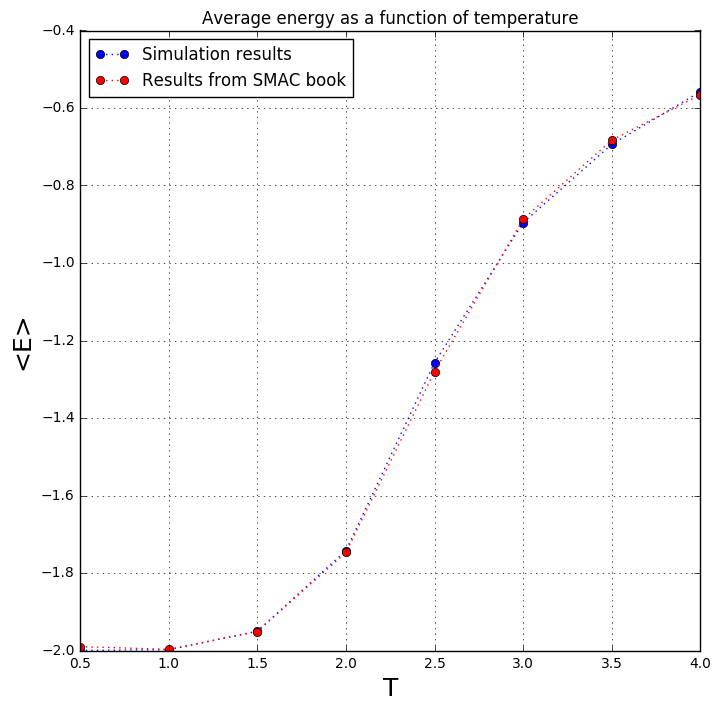

In [5]:
figure = plt.figure(figsize=(8,8))
plt.plot(temps, energies, ls= ':', marker = 'o', label="Simulation results")
plt.plot(temps, smac_energies, ls = ':', marker = 'o', color='red', label = "Results from SMAC book")
plt.xlabel("T", fontsize = 18)
plt.ylabel("<E>",fontsize=18)
plt.grid()
plt.legend(loc="upper left")
plt.title("Average energy as a function of temperature")
plt.show()
plt.close()

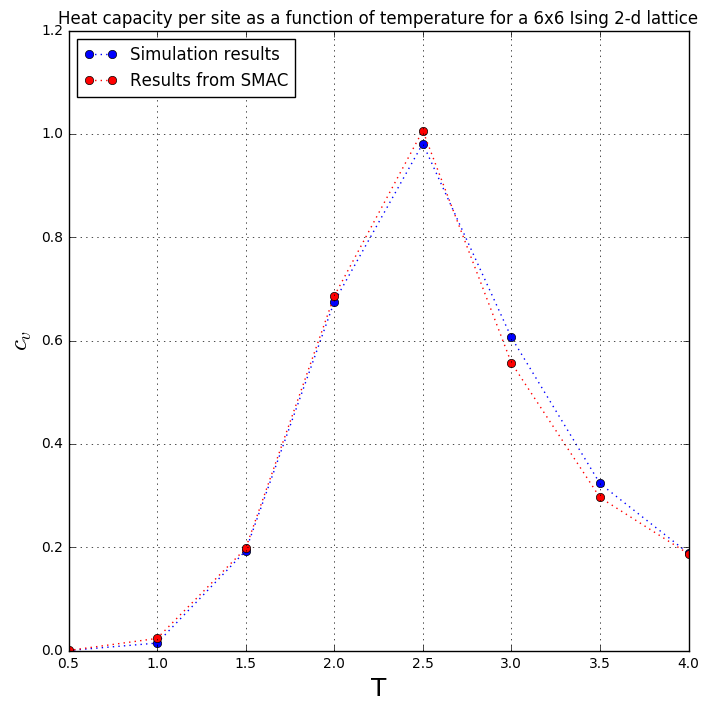

In [6]:
figure = plt.figure(figsize=(8,8))
plt.plot(temps, cv, ls= ':', marker = 'o', label="Simulation results")
plt.plot(temps, smac_cvs, ls = ':', color='red', marker = 'o', label = "Results from SMAC")
plt.legend(loc="upper left")
plt.ylabel("$c_v$", fontsize=18)
plt.xlabel("T", fontsize=18)
plt.title("Heat capacity per site as a function of temperature for a 6x6 Ising 2-d lattice")
plt.grid()
plt.show()
plt.close()

Quite clearly, the results obtained are in very good agreement with the SMAC book's values. Let's now see how, for instance, how the average energy converges to the SMAC value in function of the Monte-Carlo iteration time. To do this, we have an array called energy_time whose i-th component contains the average energy computed up to the i-th iteration.

In [8]:
temps = np.arange(0.5,4.5,0.5)
config = ising_2d(6,1./temps[-1])
energy_time = [config.energy()/config.N]
time = range(100000)
for i in time:
    config.local_mc()
    energy_time.append((energy_time[-1]*(i+1)+config.energy()/config.N)/(i+2))
energy_time.pop()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


-0.55965107015597559

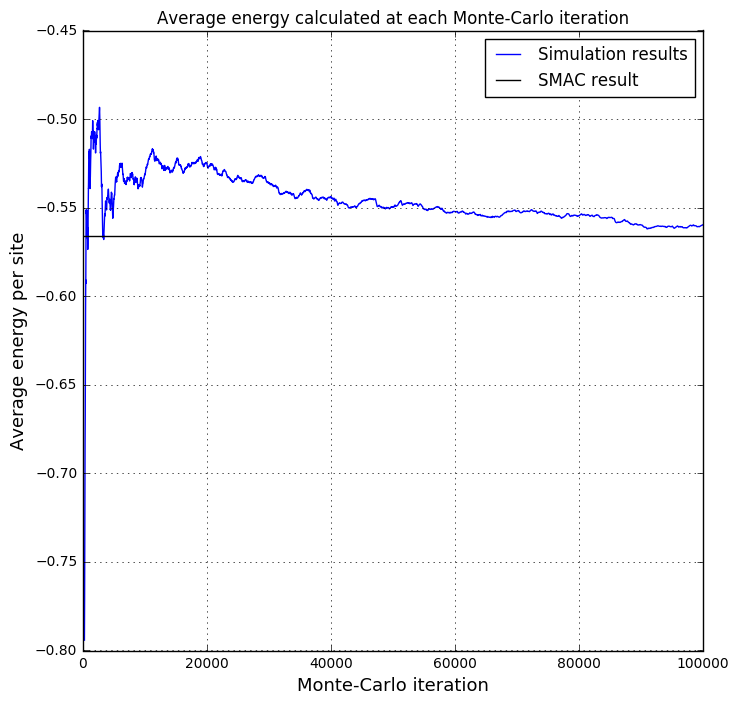

In [11]:
fig = plt.figure(figsize=(8,8))
plt.plot(time[250:], energy_time[250:], lw=1,label="Simulation results")
#we remove the first 250 points, they are too noisy because of the thermalization time
plt.axhline(y=smac_energies[-1], xmin=0,xmax=10000, color = 'k', label= "SMAC result")
plt.xlabel("Monte-Carlo iteration", fontsize=13)
plt.ylabel("Average energy per site", fontsize=13)
plt.title("Average energy calculated at each Monte-Carlo iteration")
plt.legend()
plt.grid()
plt.show()
plt.close()

We can see that the simulation results seem to converge to the SMAC result, albeit quite slowly. This is quite normal, as the error in the Monte-Carlo simulation only decreases as $\frac{1}{\sqrt{N}}$, a rather slow decrease. 

Let us now see more explicitely how the error depends on the temperature using the bunching algorithm.

In [12]:
def bunching(array):
    new_array = []
    while array!=[]:
        x = array.pop()
        y = array.pop()
        new_array.append((x+y)/2.)
    return new_array

def get_error(array, iters=20):
    error = []
    array_copy = list(array)
    for i in xrange(iters):
        error.append(np.std(array_copy)/np.sqrt(len(array_copy)))
        array_copy = bunching(array_copy)
    return error

In [13]:
#we take temperatures far from Tc, and temperatures close to Tc
test_temps = [0.25,0.5,2,2.2,10.0,20.0]

In [14]:
error = []
print "======================================="
for temp in test_temps:
    print "Calculating for T="+str(temp)+": :",
    config = ising_2d(6, 1./temp)
    energies = []
    for i in xrange(2**17):
        energies.append(config.energy())
        config.local_mc()
        if i%(2**17/10)==0 and i>0: print str(np.ceil(i/2.**17*100))+"%....",
    print "100% DONE"
    error.append(get_error(energies, iters=16))

Calculating for T=0.25: :

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... 100% DONE
Calculating for T=0.5: : 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... 100% DONE
Calculating for T=2: : 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... 100% DONE
Calculating for T=2.2: : 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... 100% DONE
Calculating for T=10.0: : 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... 100% DONE
Calculating for T=20.0: : 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... 100% DONE


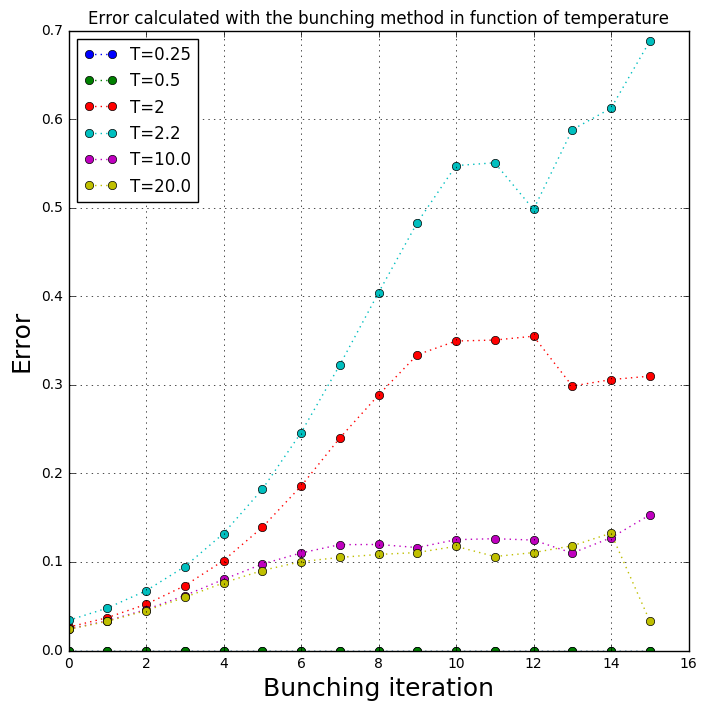

In [15]:
figure = plt.figure(figsize=(8,8))
iters = range(16)
for i in range(len(test_temps)):
    plt.plot(iters, error[i], ls= ':', marker = 'o', label="T="+str(test_temps[i]))
plt.legend(loc="upper left")
plt.ylabel("Error", fontsize=18)
plt.xlabel("Bunching iteration", fontsize=18)
plt.title("Error calculated with the bunching method in function of temperature")
plt.grid()
plt.show()
plt.close()

Again it is quite clear that the errors we get are extremely high when we are close to Tc. To get a more precise look, let's look at the error in function of temperature at fixed bunching iteration. 

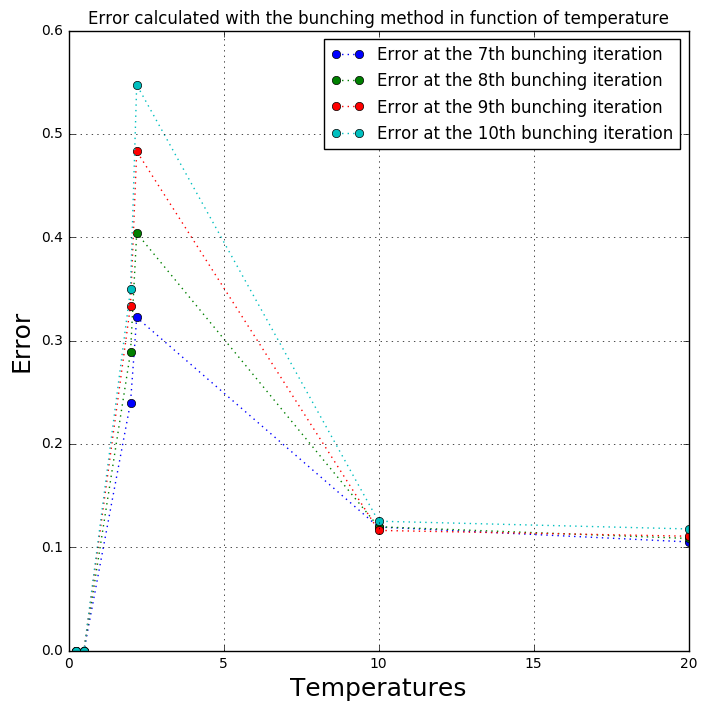

In [18]:
figure = plt.figure(figsize=(8,8))
error = np.asarray(error)
for i in range(7,11):
    plt.plot(test_temps, error[:,i], ls= ':', marker = 'o', label="Error at the "+str(i)+"th bunching iteration")
plt.legend(loc="upper right")
plt.ylabel("Error", fontsize=18)
plt.xlabel("Temperatures", fontsize=18)
plt.title("Error calculated with the bunching method in function of temperature")
plt.grid()
plt.show()
plt.close()

Quite clearly, the error is very high close to the critical temperature. This is due to the critical slowing down : the local Monte-Carlo algorithm has a very hard time sampling all configurations close to the critical temperature because of the very long correlation length. As we will see, this is not a problem when using the Wolff cluster algorithm.

We can also see we get a very small error at low temperature. This is natural, as the physically acceptable configurations at low temperatures are only two : the lattice where all spins are -1 and the one where all spins are +1. Once one of these two configurations is reached, the local monte-carlo algorithm is "stuck" in it, and always measures the same configuration (which raises the question of ergodicity below the critical temperature for the local monte-carlo algorithm as well). 

# Part II

1 . Let's compute the average cluster size using Wolff's algorithm. This is easy given the usage of the ising2d class : the cluster_mc() method flips a cluster and returns the size of the cluster. 

In [15]:
sizes = []
temps = np.arange(0.5,4.5,0.5)
print "================================================"
print "Calculating "
for T in temps:
    print "T = "+str(T)+": ",
    config = ising_2d(32,1./T)
    avg_size = 0.
    for i in xrange(1000):
        avg_size += config.cluster_mc()
        if i%100==0 and i>0: print str(i/1000.*100)+"%....",
    print "100% DONE"
    sizes.append(avg_size/1000.)

Calculating 
T = 0.5: 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 1.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 1.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 3.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 3.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 4.0:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE


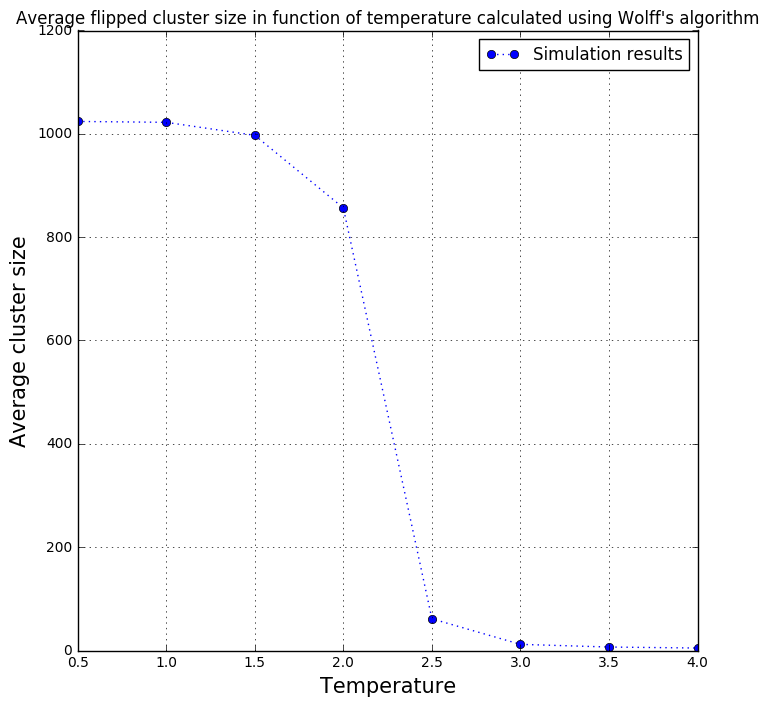

In [16]:
fig = plt.figure(figsize=(8,8))
plt.plot(temps, sizes, ls=':', marker = 'o', label = "Simulation results")
plt.legend()
plt.xlabel("Temperature", fontsize=15)
plt.ylabel("Average cluster size",fontsize=15)
plt.title("Average flipped cluster size in function of temperature calculated using Wolff's algorithm")
plt.grid()
plt.show()
plt.close()

We can see that at low temperatures, the average size of the flipped clusters is close to $1024=32\cdot 32$ which is the whole size of the 32x32 lattice. This is normal : below $T_c$ the correlation length is very large (decreases as a power law) and, since we are dealing with a finite lattice, exceeds the size of the lattice. This means that nearly all sites are correlated, which allows us to build large clusters. 

We see that the average cluster size falls rapidly around $T_c\simeq 2,27$. Afterwards, it becomes quite small. This is normal, as the high temperature Ising lattice behaves like a liquid in the sense that it has a very short correlation length, meaning that we can't build large clusters because neighboring spins don't have the same sign. 
Let's take a closer look at what happens around $T_c$.

In [17]:
sizes = []
temps = np.arange(2.0,2.6,0.1)
print "================================================"
print "Calculating "
for T in temps:
    print "T = "+str(T)+": ",
    config = ising_2d(32,1./T)
    avg_size = 0.
    for i in xrange(1000):
        avg_size += config.cluster_mc()
        if i%100==0 and i>0: print str(i/1000.*100)+"%....",
    print "100% DONE"
    sizes.append(avg_size/1000.)

Calculating 
T = 2.0: 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.1:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.2:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.3:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.4:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.5:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE
T = 2.6:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100% DONE


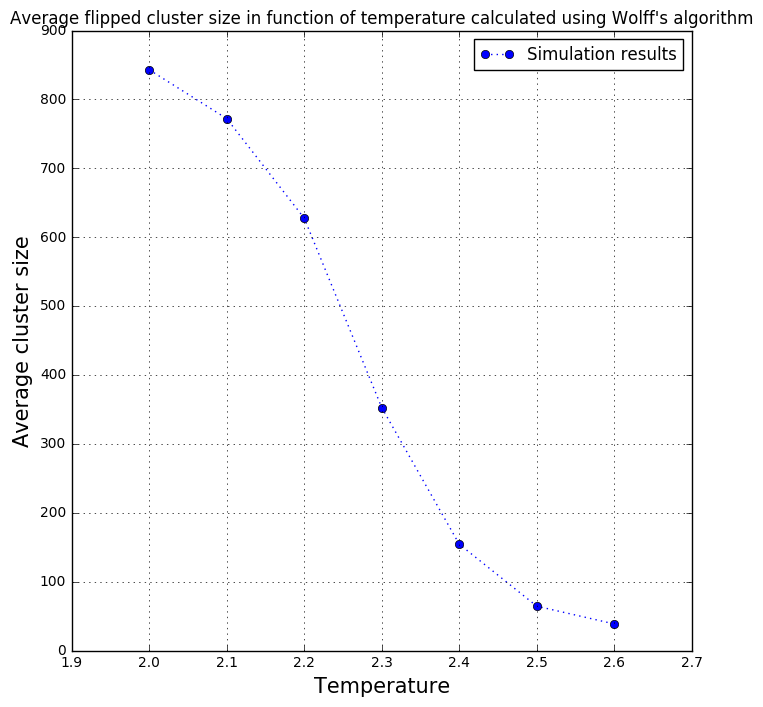

In [18]:
fig = plt.figure(figsize=(8,8))
plt.plot(temps, sizes, ls=':', marker = 'o', label = "Simulation results")
plt.legend()
plt.xlabel("Temperature", fontsize=15)
plt.ylabel("Average cluster size", fontsize =15)
plt.title("Average flipped cluster size in function of temperature calculated using Wolff's algorithm")
plt.grid()
plt.show()
plt.close()

This confirms what we said previously, the graph seems to have an inflection point close to $T_c\simeq 2,27$, and the average cluster size falls rapidly afterwards. 

2 . Let us now compare the bunching error between the local and Wolff algorithms. We will do this close to $T_c$, at $\beta=0.4$ and further away from $T_c$, at $\beta=0.2$. 

In [10]:
betas = [0.2,0.4]
iters = [14,16]
error_local = []
error_cluster = []
for i in range(len(betas)):
    print "Calculating for beta = "+str(betas[i])+": ",
    config_local = ising_2d(beta=betas[i],L=6)
    config_cluster = ising_2d(beta=betas[i],L=32)
    mag_local = []
    mag_cluster = []
    for j in xrange(2**(iters[i]+1)):
        if j>0 and j%(2**(iters[i]+1)/10)==0: print str(np.ceil(j/(2.**(iters[i]+1))*100))+"%....",
        mag_local.append(np.abs(np.sum(config_local.spins))/config_local.N)
        mag_cluster.append(np.abs(np.sum(config_cluster.spins))/config_cluster.N)
        config_local.local_mc()
        config_cluster.cluster_mc()
    print "DONE"
    error_local.append(get_error(mag_local, iters=iters[i]))
    error_cluster.append(get_error(mag_cluster, iters=iters[i]))

Calculating for beta = 0.2: 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... DONE
Calculating for beta = 0.4:  10.0%.... 20.0%.... 30.0%.... 40.0%.... 50.0%.... 60.0%.... 70.0%.... 80.0%.... 90.0%.... 100.0%.... DONE


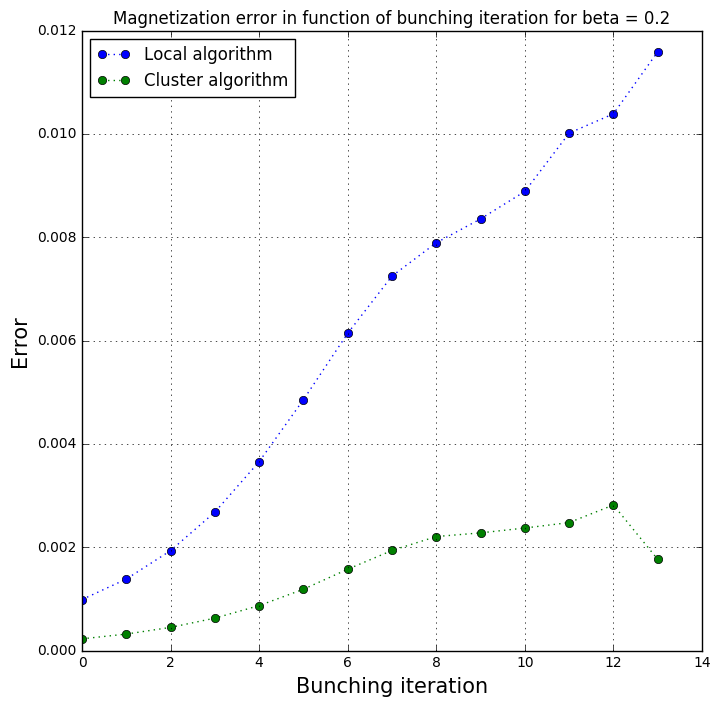

In [11]:
fig = plt.figure(figsize=(8,8))
plt.plot(range(iters[0]),error_local[0], ls=':', marker='o', label = "Local algorithm")
plt.plot(range(iters[0]),error_cluster[0], ls=':', marker='o', label = "Cluster algorithm")
plt.xlabel("Bunching iteration",fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.title("Magnetization error in function of bunching iteration for beta = "+str(betas[0]))
plt.grid()
plt.legend(loc='upper left')
plt.show()
plt.close()

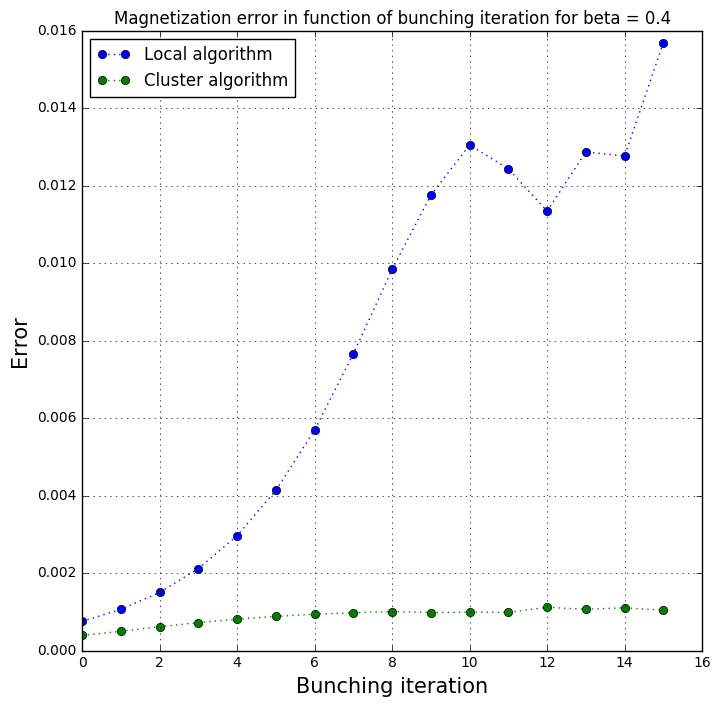

In [12]:
fig = plt.figure(figsize=(8,8))
plt.plot(range(iters[1]),error_local[1], ls=':', marker='o', label = "Local algorithm")
plt.plot(range(iters[1]),error_cluster[1], ls=':', marker='o', label = "Cluster algorithm")
plt.xlabel("Bunching iteration",fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.title("Magnetization error in function of bunching iteration for beta = "+str(betas[1]))
plt.grid()
plt.legend(loc='upper left')
plt.show()
plt.close()

It is evident in both cases that the error is much smaller for the cluster algorithm than for the local algorithm. This is due to the fact  that the cluster algorithm has a much, much smaller correlation time, in part because it doesn't reject any moves, and in part because the difference between two subsequent configurations is much bigger than for the local algorithm, meaning that we sample the available configurations space much faster (additionally, we don't encounter the aforementioned ergodicity problem at low temperature : the cluster algorithm effectively samples all configurations). 

Close to $T_c$ we see that the error for the local algorithm explodes, while the one for the cluster algorithm remains constant. This is due to the fact that there is no critical slowing down for the cluster algorithm : we don't encounter the problem of rejecting moves close to $T_c$. Furthermore, due to the infinite correlation length at $T_c$ we are able to construct and flip clusters of arbitrary size, meaning that the Monte-Carlo correlation time is very, very short, which also accounts for the fact that the bunching error close to $T_c$ for the Wolff algorithm reaches a plateau very fast. 